In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path = kagglehub.dataset_download('meowmeowmeowmeowmeow/gtsrb-german-traffic-sign')

print('Data source import complete.')


100%|██████████| 612M/612M [00:28<00:00, 22.8MB/s]

Extracting files...


Data source import complete.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import concurrent.futures
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Enable GPU usage

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and will be used for training.")
else:
    print("GPU is not available. Using CPU.")

GPU is available and will be used for training.


# Paths to your Train and Test folders (update these paths)

In [4]:
TRAIN_DIR = meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path
TEST_DIR = meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path
META_CSV = meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path + "/Meta.csv"
TRAIN_CSV = meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path + "/Train.csv"
TEST_CSV = meowmeowmeowmeowmeow_gtsrb_german_traffic_sign_path + "/Test.csv"

# Load CSV data

In [5]:
meta_df = pd.read_csv(META_CSV)
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Create a dictionary to map SignId to Sign names from Meta.csv

In [6]:
sign_id_to_name = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}

# Loading training data function with uniform resizing and cropping based on coordinates in Train.csv

In [7]:
TARGET_SIZE = (75, 75)  # Define a consistent size for all images

In [8]:
def load_image(image_path, roi_coords=None):
    image = Image.open(image_path).convert('RGB')  # Ensure 3 channels (RGB)
    if roi_coords:
        image = image.crop(roi_coords)  # Crop based on the provided coordinates
    image = image.resize(TARGET_SIZE)  # Resize to target size
    return np.array(image, dtype=np.float32)

In [9]:
def load_train_data(train_csv, data_dir):
    images = []
    labels = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_image = {}
        for _, row in train_csv.iterrows():
            image_path = os.path.join(data_dir, row['Path'])
            roi_coords = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
            future = executor.submit(load_image, image_path, roi_coords)
            future_to_image[future] = row['ClassId']

        for future in concurrent.futures.as_completed(future_to_image):
            image = future.result()
            label = future_to_image[future]
            images.append(image)
            labels.append(label)

    images = np.stack(images, axis=0)  # Stack images into a uniform array
    labels = np.array(labels)
    return images, labels

# Loading test data function with uniform resizing and cropping based on coordinates in Test.csv

In [10]:
def load_test_data(test_csv, data_dir):
    images = []
    labels = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_image = {}
        for _, row in test_csv.iterrows():
            image_path = os.path.join(data_dir, row['Path'])
            roi_coords = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
            future = executor.submit(load_image, image_path, roi_coords)
            future_to_image[future] = row['ClassId']

        for future in concurrent.futures.as_completed(future_to_image):
            image = future.result()
            label = future_to_image[future]
            images.append(image)
            labels.append(label)

    images = np.stack(images, axis=0)  # Stack images into a uniform array
    labels = np.array(labels)
    return images, labels

# Load the training and testing data

In [11]:
train_images, train_labels = load_train_data(train_df, TRAIN_DIR)
test_images, test_labels = load_test_data(test_df, TEST_DIR)

# Normalize image data

In [12]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding

In [13]:
train_labels = to_categorical(train_labels, num_classes=43)
test_labels = to_categorical(test_labels, num_classes=43)

# Train/validation split

In [14]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Data augmentation using TensorFlow's image augmentation pipeline

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomHeight(0.1),
    tf.keras.layers.RandomWidth(0.1),
])

# Building a custom CNN model

In [16]:
model = Sequential([
    # First Block
    Conv2D(64, (3, 3), activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Second Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Third Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Fourth Block
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    # Fifth Block
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    # Flattening
    Flatten(),

    # Fully Connected Layers
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(43, activation='softmax')
])

# Summary to check the deeper architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 73, 73, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 73, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 36, 36, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 36, 36, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 36, 36, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 36, 36, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 36, 36, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 17,689,387 (67.48 MB)

 Trainable params: 17,676,971 (67.43 MB)

 Non-trainable params: 12,416 (48.50 KB)

# Compile the model

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add callbacks for early stopping and learning rate reduction

In [18]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model using data augmentation

In [19]:
steps_per_epoch = max(1, len(train_images) // 64)

if len(train_images) > 0:
    model.fit(
        tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        .map(lambda x, y: (tf.image.random_brightness(x, max_delta=0.2), y))
        .map(lambda x, y: (tf.image.random_contrast(x, 0.8, 1.2), y))
        .shuffle(buffer_size=1024)
        .batch(64),
        epochs=20,
        validation_data=(val_images, val_labels),
        steps_per_epoch=steps_per_epoch,
        callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 153s 238ms/step - accuracy: 0.0255 - loss: 5.0959 - val_accuracy: 0.0658 - val_loss: 3.5952 - learning_rate: 1.0000e-04
Epoch 2/20
  1/490 ━━━━━━━━━━━━━━━━━━━━ 1:58:49 15s/step - accuracy: 0.0000e+00 - loss: 4.3373

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


490/490 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.0000e+00 - loss: 4.3373 - val_accuracy: 0.0699 - val_loss: 3.6034 - learning_rate: 1.0000e-04
Epoch 3/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 106s 217ms/step - accuracy: 0.0715 - loss: 4.1065 - val_accuracy: 0.1905 - val_loss: 2.9653 - learning_rate: 1.0000e-04
Epoch 4/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0000e+00 - loss: 6.4906 - val_accuracy: 0.1892 - val_loss: 2.9646 - learning_rate: 1.0000e-04
Epoch 5/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 102s 209ms/step - accuracy: 0.1395 - loss: 3.4564 - val_accuracy: 0.2467 - val_loss: 2.6742 - learning_rate: 1.0000e-04
Epoch 6/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.1429 - loss: 3.7075 - val_accuracy: 0.2396 - val_loss: 2.7219 - learning_rate: 1.0000e-04
Epoch 7/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 106s 215ms/step - accuracy: 0.2434 - loss: 2.8312 - val_accuracy: 0.3602 - val_loss: 2.0335 - learning_rate: 1.0000e-04
Epoch 8/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/ste

# Evaluate the model on the validation set

In [26]:
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9882 - loss: 0.0444
Validation Accuracy: 98.94%


# Predictions for evaluation metrics

In [27]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step


# Calculate evaluation metrics

In [28]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print evaluation metrics

In [29]:
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Confusion Matrix:
[[ 46   0   0 ...   0   0   0]
 [  0 716   4 ...   0   0   0]
 [  0   3 737 ...   0   0   0]
 ...
 [  0   0   0 ...  88   0   0]
 [  0   0   0 ...   0  38   0]
 [  0   0   0 ...   0  15  70]]
Accuracy: 96.06%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


# Show a few example predictions

In [30]:
def show_predictions(images, labels, model, num=5):
    if len(images) > 0:
        indices = np.random.choice(len(images), num, replace=False)
        for i in indices:
            image = images[i]
            true_label = np.argmax(labels[i])
            prediction = np.argmax(model.predict(image.reshape(1, TARGET_SIZE[0], TARGET_SIZE[1], 3)))
            true_sign_name = sign_id_to_name.get(true_label, "Unknown")
            predicted_sign_name = sign_id_to_name.get(prediction, "Unknown")
            plt.imshow((image * 255).astype(np.uint8))  # Convert back to 0-255 range for display
            plt.title(f'True: {true_sign_name}, Predicted: {predicted_sign_name}')
            plt.axis('off')
            plt.show()

# Show some predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


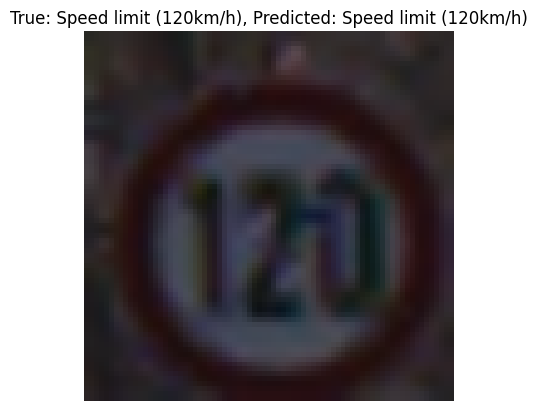

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


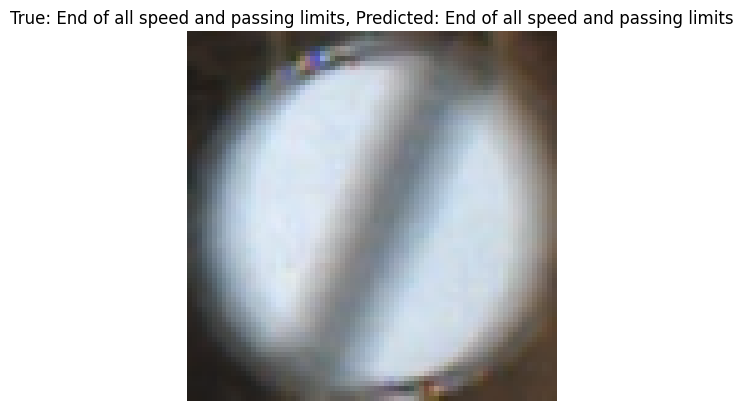

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


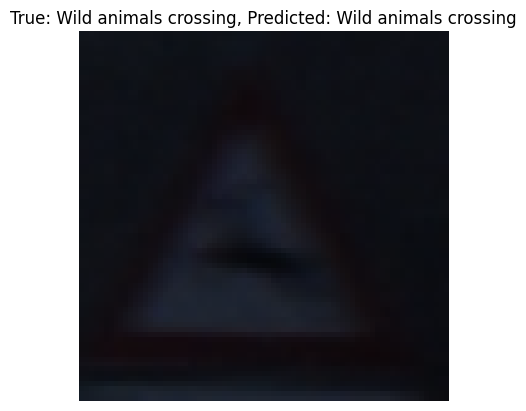

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


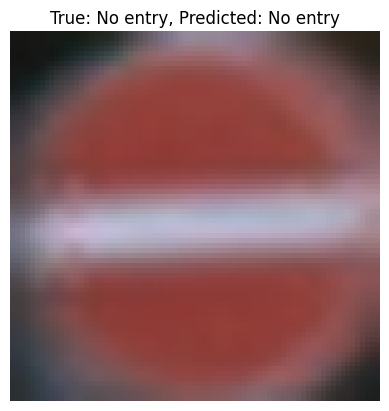

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


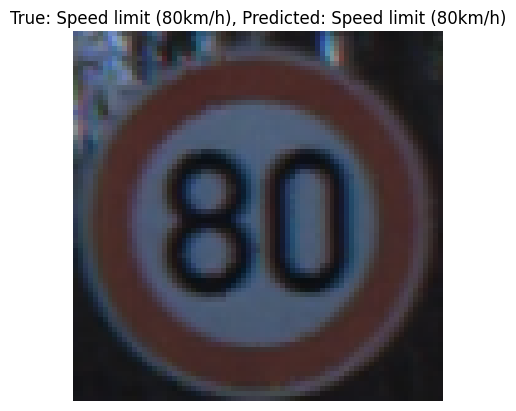

In [31]:
show_predictions(test_images, test_labels, model)